In [1]:
import os
import time
import pandas as pd
import torch
import optuna
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Admin\anaconda3\envs\chandra\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset

In [2]:
df = pd.read_csv('final_dataset.csv')

In [3]:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

c:\Users\Admin\anaconda3\envs\chandra\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:
train_encodings = tokenizer.batch_encode_plus(X_train.tolist(),
                                              add_special_tokens=True,
                                              max_length=128,
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_tensors='pt')

In [6]:
test_encodings = tokenizer.batch_encode_plus(X_test.tolist(),
                                             add_special_tokens=True,
                                             max_length=128,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_tensors='pt')

In [7]:
label_mapping = {'fake': 0, 'genuine': 1}

In [8]:
y_train_num = [label_mapping[label] for label in y_train]
y_test_num = [label_mapping[label] for label in y_test]

In [9]:
class YelpDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: v.clone().detach() for k, v in encodings.items()}
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = YelpDataset(train_encodings, y_train_num)
test_dataset = YelpDataset(test_encodings, y_test_num)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
def save_checkpoint(model, optimizer, epoch, batch_idx, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

In [13]:
def load_checkpoint(model, optimizer, path='checkpoint.pth'):
    if os.path.isfile(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch_idx = checkpoint['batch_idx']
        return epoch, batch_idx
    else:
        return None, None

In [14]:
train_losses = []
train_accuracies = []

In [15]:
def train(model, device, loader, optimizer, start_epoch, start_batch_idx, criterion, patience=3):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()
    checkpoint_interval = 30 * 60  # 30 minutes in seconds
    best_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(start_epoch, 5):  # Adjust the range as needed
        epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_predictions = 0
        for batch_idx, batch in enumerate(loader):
            if epoch == start_epoch and batch_idx < start_batch_idx:
                continue  # Skip batches already processed in the previous run
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            epoch_loss += loss.item()

            # Calculate training accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            epoch_correct_predictions += (predictions == labels).sum().item()
            epoch_total_predictions += labels.size(0)

            # Check if 30 minutes have passed
            elapsed_time = time.time() - start_time
            if (elapsed_time >= checkpoint_interval):
                print(f'Saving checkpoint at epoch {epoch}, batch {batch_idx}')
                save_checkpoint(model, optimizer, epoch, batch_idx)
                start_time = time.time()  # Reset the start time
        avg_epoch_loss = epoch_loss / len(loader)
        epoch_accuracy = epoch_correct_predictions / epoch_total_predictions
        print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Early stopping
        if (avg_epoch_loss < best_loss):
            best_loss = avg_epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if (epochs_no_improve == patience):
                print(f'Early stopping at epoch {epoch+1}')
                break
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [16]:
def evaluate(model, device, loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [17]:
def plot_roc_curve(true_labels, predictions, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, hidden_dropout_prob=dropout_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    avg_loss, accuracy = train(model, device, train_loader, optimizer, 0, 0, criterion)
    predictions, true_labels = evaluate(model, device, test_loader)
    test_accuracy = accuracy_score(y_test_num, predictions)
    
    return test_accuracy

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-07-16 00:31:02,197] A new study created in memory with name: no-name-c40c0cea-ea65-44ac-a22d-84cda4613a40
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a

Epoch 1, Loss: 0.4860, Accuracy: 0.7847
Epoch 2, Loss: 0.4085, Accuracy: 0.8140
Epoch 3, Loss: 0.3904, Accuracy: 0.8215
Epoch 4, Loss: 0.3802, Accuracy: 0.8286
Saving checkpoint at epoch 4, batch 7
Epoch 5, Loss: 0.3741, Accuracy: 0.8306


[I 2024-07-16 01:09:27,139] Trial 0 finished with value: 0.8383838383838383 and parameters: {'learning_rate': 1.7435160406078229e-06, 'batch_size': 16, 'dropout_rate': 0.4234079341737522}. Best is trial 0 with value: 0.8383838383838383.
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert

Epoch 1, Loss: 0.3917, Accuracy: 0.8234
Epoch 2, Loss: 0.3430, Accuracy: 0.8470
Epoch 3, Loss: 0.3063, Accuracy: 0.8641
Saving checkpoint at epoch 3, batch 2702
Epoch 4, Loss: 0.2667, Accuracy: 0.8821
Epoch 5, Loss: 0.2273, Accuracy: 0.9026


[I 2024-07-16 01:52:56,069] Trial 1 finished with value: 0.8356715301159746 and parameters: {'learning_rate': 1.9475631282951883e-05, 'batch_size': 8, 'dropout_rate': 0.29910822139668475}. Best is trial 0 with value: 0.8383838383838383.
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert

Epoch 1, Loss: 0.3944, Accuracy: 0.8240
Epoch 2, Loss: 0.3515, Accuracy: 0.8416
Epoch 3, Loss: 0.3306, Accuracy: 0.8520
Saving checkpoint at epoch 3, batch 2672
Epoch 4, Loss: 0.3114, Accuracy: 0.8625
Epoch 5, Loss: 0.2925, Accuracy: 0.8730


[I 2024-07-16 02:36:28,986] Trial 2 finished with value: 0.8424055368499813 and parameters: {'learning_rate': 2.203810599878767e-06, 'batch_size': 8, 'dropout_rate': 0.19495923953894054}. Best is trial 2 with value: 0.8424055368499813.
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-

Epoch 1, Loss: 0.3849, Accuracy: 0.8251
Epoch 2, Loss: 0.3341, Accuracy: 0.8513
Epoch 3, Loss: 0.2895, Accuracy: 0.8719
Epoch 4, Loss: 0.2411, Accuracy: 0.8975
Saving checkpoint at epoch 4, batch 472
Epoch 5, Loss: 0.1916, Accuracy: 0.9219


[I 2024-07-16 03:11:35,745] Trial 3 finished with value: 0.8330527497194163 and parameters: {'learning_rate': 3.0452320158581174e-05, 'batch_size': 32, 'dropout_rate': 0.2616718458055485}. Best is trial 2 with value: 0.8424055368499813.
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11648\1509879558.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert

Epoch 1, Loss: 0.4100, Accuracy: 0.8169
Epoch 2, Loss: 0.3591, Accuracy: 0.8379
Epoch 3, Loss: 0.3412, Accuracy: 0.8482
Saving checkpoint at epoch 3, batch 2652
Epoch 4, Loss: 0.3248, Accuracy: 0.8553
Epoch 5, Loss: 0.3092, Accuracy: 0.8634


[I 2024-07-16 03:55:10,927] Trial 4 finished with value: 0.8434343434343434 and parameters: {'learning_rate': 1.8849880982285386e-06, 'batch_size': 8, 'dropout_rate': 0.21521677212039264}. Best is trial 4 with value: 0.8434343434343434.


In [20]:
best_trial = study.best_trial
print(f'Best trial: Value: {best_trial.value}, Params: {best_trial.params}')

Best trial: Value: 0.8434343434343434, Params: {'learning_rate': 1.8849880982285386e-06, 'batch_size': 8, 'dropout_rate': 0.21521677212039264}


Use the best hyperparameters to train the final model

In [21]:
best_params = best_trial.params
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']

In [22]:
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, hidden_dropout_prob=best_dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.21521677212039264, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [25]:
avg_loss, accuracy = train(model, device, train_loader, optimizer, 0, 0, criterion)

Epoch 1, Loss: 0.3994, Accuracy: 0.8213
Epoch 2, Loss: 0.3551, Accuracy: 0.8408
Epoch 3, Loss: 0.3367, Accuracy: 0.8506
Saving checkpoint at epoch 3, batch 2699
Epoch 4, Loss: 0.3218, Accuracy: 0.8566
Epoch 5, Loss: 0.3072, Accuracy: 0.8646


In [26]:
predictions, true_labels = evaluate(model, device, test_loader)
test_accuracy = accuracy_score(y_test_num, predictions)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Test Accuracy: 0.8411


In [27]:
def predict(model, tokenizer, text, device):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    return 'genuine' if predictions.item() == 1 else 'fake'

In [28]:
user_input = "These were lightweight and soft but much too small for my liking. I would have preferred two of these together to make one loc. For that reason I will not be repurchasing."
prediction = predict(model, tokenizer, user_input, device)
print(f'Predicted class: {prediction}')

Predicted class: fake


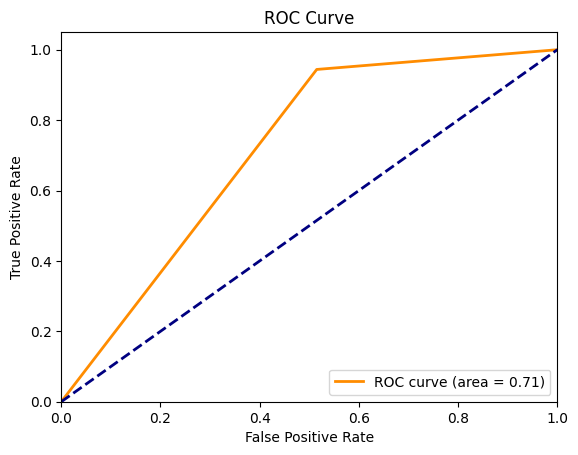

In [29]:
plot_roc_curve(y_test_num, predictions)

In [30]:
epochs = list(range(1, len(train_losses) + 1))

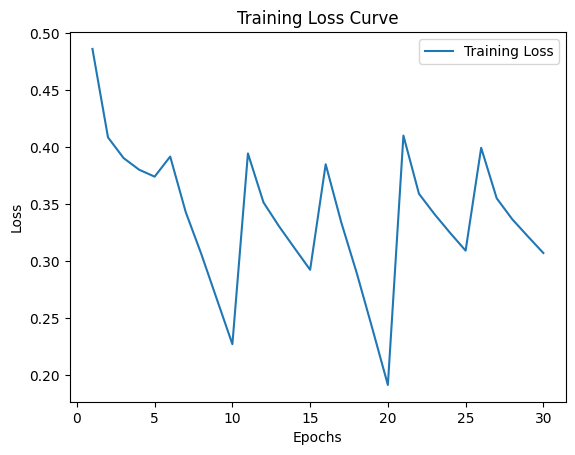

In [31]:
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

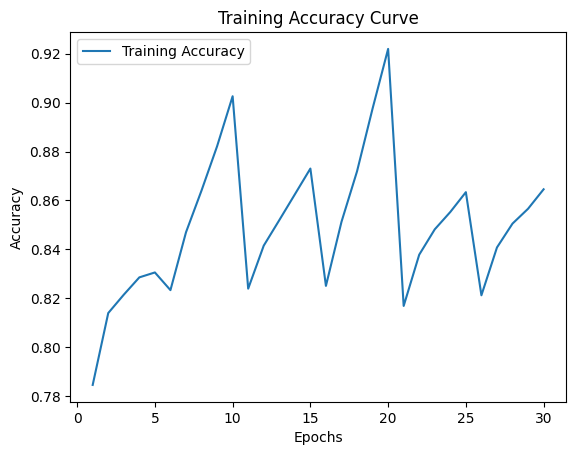

In [32]:
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

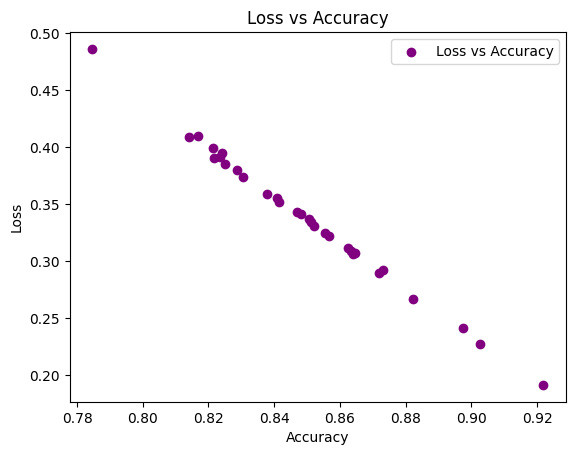

In [33]:
plt.figure()
plt.scatter(train_accuracies, train_losses, label='Loss vs Accuracy', color='purple')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Loss vs Accuracy')
plt.legend()
plt.show()